# Explosion detector

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
plt.rc('image', cmap='magma_r')

Define the coordinate system

In [2]:
NUM_POINTS = 5000
LAPS = 50

radius = np.arange(1, NUM_POINTS + 1) / NUM_POINTS
theta = LAPS * 2 * np.pi * radius
spiral_x = radius * np.cos(theta)
spiral_y = radius * np.sin(theta)
spiral_locations = np.column_stack((spiral_x, spiral_y))

Define the locations of the detection stations on the surface:

In [3]:
NUM_SENSORS = 10
sensors = np.arange(1, NUM_SENSORS + 1)
sensors_theta = 2 * np.pi * sensors / NUM_SENSORS
sensors_x = np.cos(sensors_theta)
sensors_y = np.sin(sensors_theta)
sensors_locations = np.column_stack((sensors_x, sensors_y))

Plot all locations:

In [4]:
def plot_sensor_value(theta, value, scaling, color, label=None):
    radius = (1 + value * scaling)
    ini_x = np.cos(theta)
    ini_y = np.sin(theta)
    fin_x = radius * ini_x
    fin_y = radius * ini_y
    plt.plot([ini_x, fin_x], [ini_y, fin_y],
             color=color, label=label)

def plot_earth(spiral_locations, sensors_thetas,
               colors=None, sensors_values=None, alpha=0.15,
               spiral_markers_size=2, sensors_markers_size=50,
               figure_size=8, delta_degrees=1, values_scaling=0.2):
    plt.figure(figsize=(figure_size, figure_size))
    plt.axis('equal')
    plt.grid()

    # Spiral locations
    spiral_x, spiral_y = spiral_locations.T
    plt.plot(spiral_x, spiral_y, alpha=alpha)
    spiral_kwargs = {}
    if colors is not None:
        spiral_kwargs['c'] = colors
    plt.scatter(spiral_x, spiral_y, spiral_markers_size, **spiral_kwargs)
    if colors is not None:
        plt.colorbar()

    # Stations
    sensors_x = np.cos(sensors_theta)
    sensors_y = np.sin(sensors_theta)
    delta_theta = np.radians(delta_degrees)
    if sensors_values is not None:
        clean_values, noisy_values = sensors_values
        label = True
        for clean, noisy, theta in zip(clean_values, noisy_values, sensors_theta):
            clean_theta = theta - delta_theta
            noisy_theta = theta + delta_theta
            if label:
                plot_sensor_value(clean_theta, clean, values_scaling, color='firebrick', label='Theoretical')
                plot_sensor_value(noisy_theta, noisy, values_scaling, color='green', label='Measured')
                label = False
            else:
                plot_sensor_value(clean_theta, clean, values_scaling, color='firebrick')
                plot_sensor_value(noisy_theta, noisy, values_scaling, color='green')
    plt.scatter(sensors_x, sensors_y, sensors_markers_size, label='Sensors')

    plt.legend()

<IPython.core.display.Javascript object>


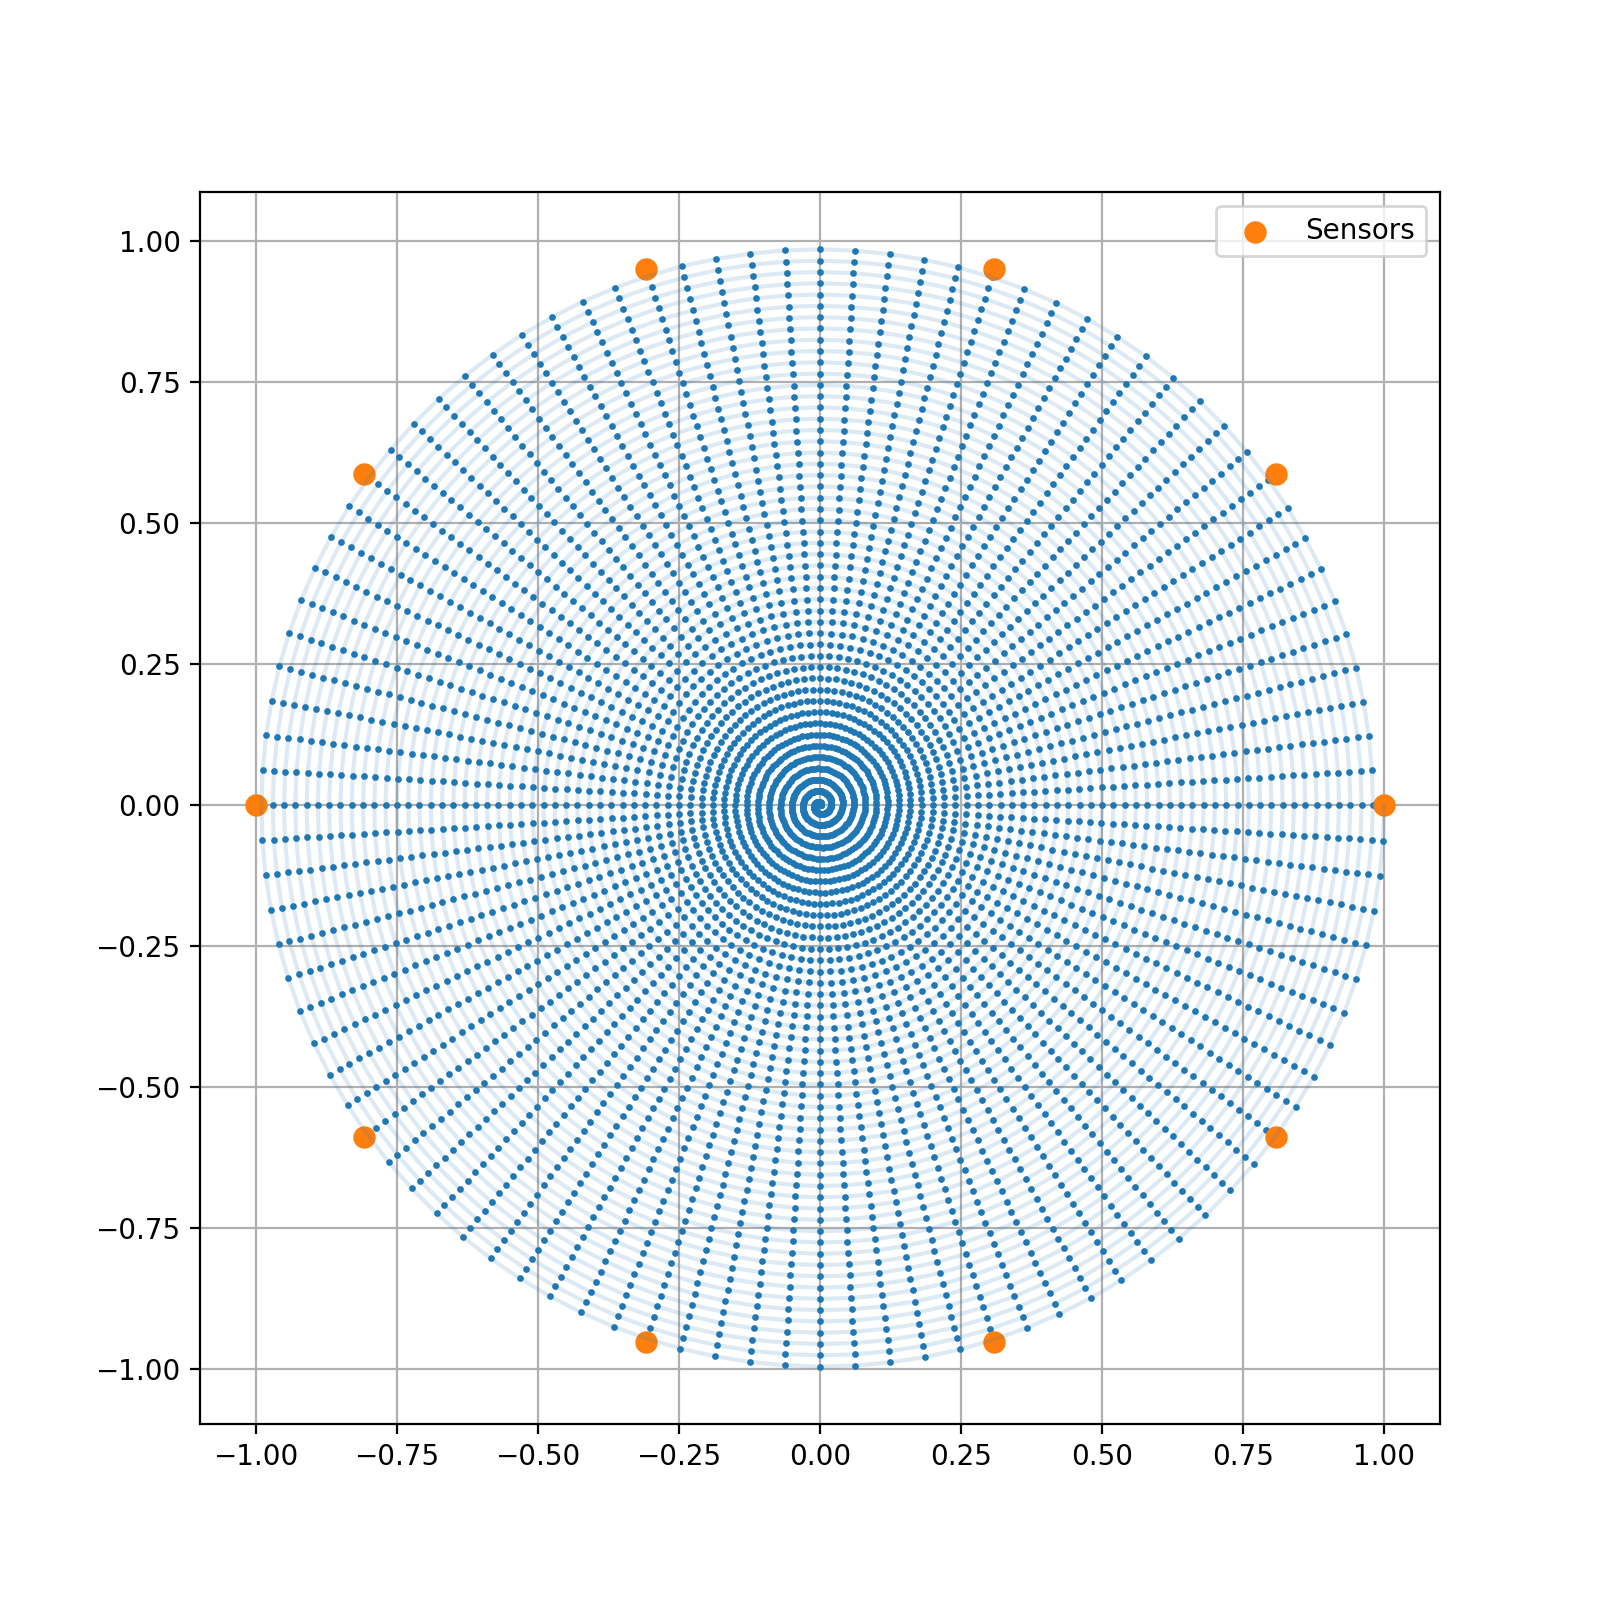

In [5]:
plot_earth(spiral_locations, sensors_locations)

Define what value on each sensor would be generated by an explosion at internal spiral location:

In [6]:
def detected_values(earthquake_locations, sensor_location):
    diff = earthquake_locations - sensor_location
    d = np.linalg.norm(diff, axis=1)
    measured = 1 / (d**2 + 0.1)
    return measured

In [7]:
v = np.empty((NUM_POINTS, NUM_SENSORS))
for i, sensor_location in enumerate(sensors_locations):
    v[:, i] = detected_values(spiral_locations, sensor_location)

Make the explosion data:

In [8]:
true_earthquake_idx = np.random.choice(len(spiral_locations))
true_earthquake_location = spiral_locations[true_earthquake_idx]

Standard deviation $\sigma$ of the Gaussian noise:

In [9]:
sigma = 1

Get the noisy sensor values that will be observed for this explosion:

In [10]:
values_clean = detected_values(true_earthquake_location, sensors_locations)
values_noisy = values_clean + sigma * np.random.randn(NUM_SENSORS)

<IPython.core.display.Javascript object>


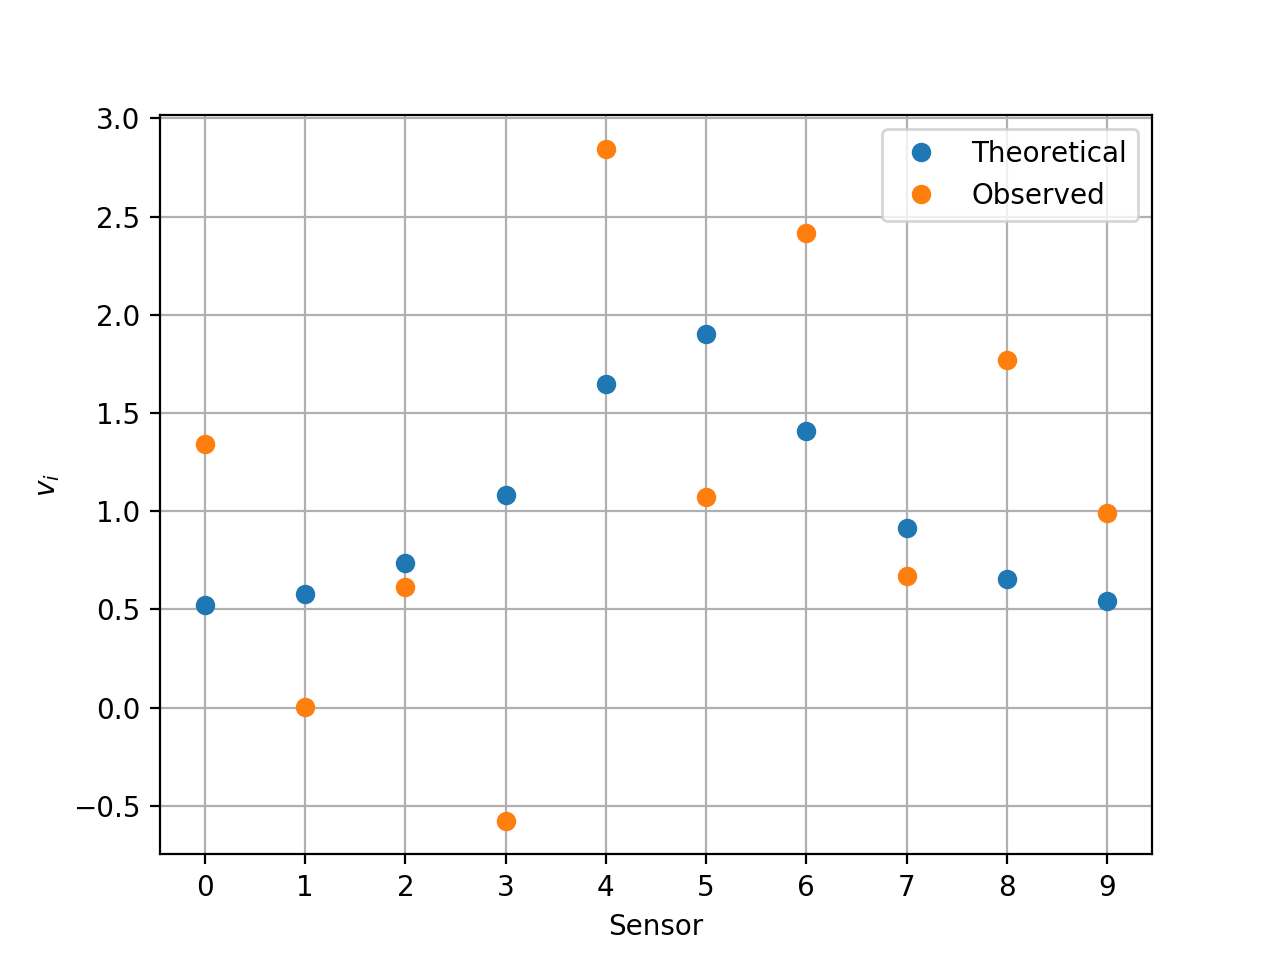

In [11]:
plt.figure()

plt.plot(values_clean, 'o', label='Theoretical')
plt.plot(values_noisy, 'o', label='Observed')
plt.xticks(range(NUM_SENSORS))
plt.xlabel('Sensor')
plt.ylabel('$v_i$')

plt.grid()
plt.legend()
plt.show()

Perform inference $p(\text{location}|\text{observed sensor values}) = p(e_x, e_y | v_1, \dots, v_N)$ given the sensor values:
\begin{equation}
    p(e_x, e_y | v_1, \dots, v_N) \propto  \prod_{i=1}^{N} p(v_i | d_i) \\   
    p(v_i | d_i) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2 \sigma^2} \left(v_i - \frac{1}{d_i^2 + 0.1}\right)^2} \\
    v_i = n_i \\
    \frac{1}{d_i^2 + 0.1} = c_i \\
    p(v_i | d_i) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{\left(n_i - c_i\right)^2}{2 \sigma^2}} \\
    \log{p(v_i | d_i)} = -\frac{\left(n_i - c_i\right)^2}{2 \sigma^2} - \log{\sqrt{2 \pi \sigma^2}} \\
    \log{p(v_i | d_i)} \propto -0.5 \frac{\left(n_i - c_i\right)^2}{\sigma^2} \\
    \log{p(e_x, e_y | v_1, \dots, v_N)} \propto \sum_{i=1}^{N} -0.5 \frac{\left(n_i - c_i\right)^2}{\sigma^2} \\
    p(e_x, e_y | v_1, \dots, v_N) \propto e^{\left(\sum_{i=1}^{N} -0.5 \frac{\left(n_i - c_i\right)^2}{\sigma^2} \right)} 
\end{equation}

In [12]:
# This is not optimised (yet)
logp = np.zeros((NUM_POINTS, 1))
for spiral_idx in range(NUM_POINTS):
    for sensor_idx in range(NUM_SENSORS):
        # Gaussian distribution
        logp[spiral_idx] += -0.5 * (values_noisy[sensor_idx] - v[spiral_idx, sensor_idx])**2 / (sigma**2)
p = np.exp(logp) # do exponentiation (and avoid over/underflow)
p /= p.sum() # normalise

Plot the posterior and most likely location of the explosion:

<IPython.core.display.Javascript object>


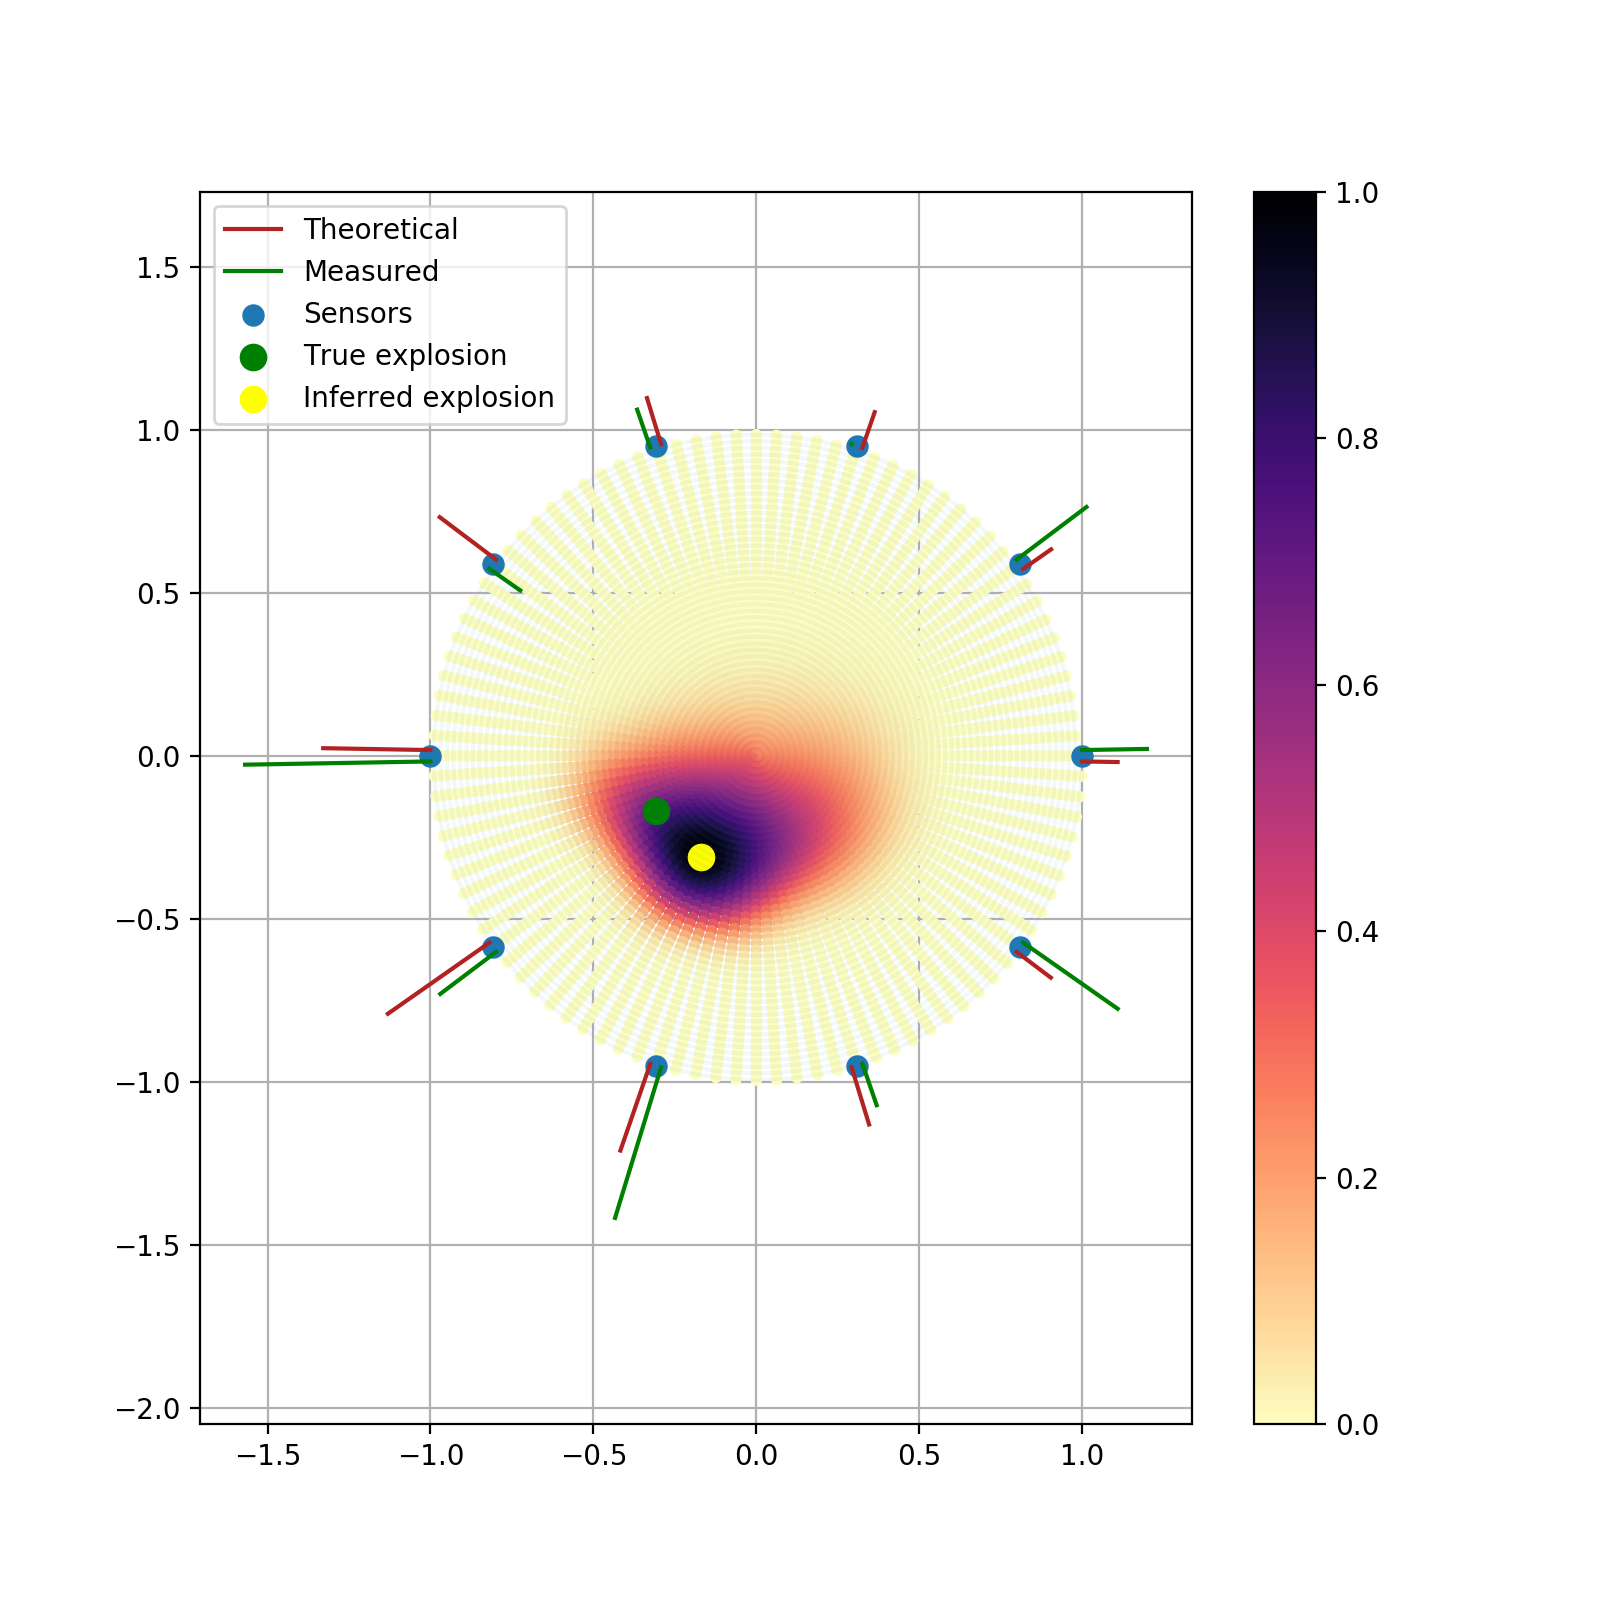

In [13]:
p_max_index = np.argmax(p)
colors = p / p.max()
colors = colors.ravel()
plot_earth(spiral_locations, sensors_locations,
           colors=colors, alpha=0.05, spiral_markers_size=10,
           sensors_values=(values_clean, values_noisy))
ex, ey = true_earthquake_location
plt.scatter(ex, ey, 80, c='green', label='True explosion')

pex, pey = spiral_locations[p_max_index]
plt.scatter(pex, pey, 80, c='yellow', label='Inferred explosion')

plt.legend()
plt.show()